<a href="https://colab.research.google.com/github/Dharmendra1308/CSE-Department-Portal/blob/main/Balanced_DA_HAM_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries:

In [1]:
# ==================== Basic Utilities ====================

import os                                # For interacting with the operating system (e.g., file paths)
import numpy as np                       # Numerical computing library for array operations
import pandas as pd                      # For handling tabular data (e.g., CSV, DataFrames)
import matplotlib.pyplot as plt          # Visualization library for plotting graphs and images
import seaborn as sns                    # Statistical data visualization (e.g., heatmaps, boxplots)

from collections import Counter          # To count occurrences of items (used for class distributions)

# ==================== TensorFlow and Keras ====================

import tensorflow as tf                  # TensorFlow deep learning framework

from tensorflow.keras.models import Sequential                              # Keras sequential model API
from tensorflow.keras.regularizers import l2                                # L2 regularization to prevent overfitting
from tensorflow.keras.layers import (                                       # Common neural network layers
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, Activation
)
from tensorflow.keras.preprocessing.image import (                          # Image preprocessing tools
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras.callbacks import (                                    # Callback utilities
    EarlyStopping,              # Stop training when validation loss stops improving
    ReduceLROnPlateau           # Reduce learning rate when a metric has stopped improving
)
from tensorflow.keras.optimizers import Adamax, Adam                        # Optimizers used during model training

# ==================== Scikit-learn Utilities ====================

from sklearn.model_selection import train_test_split                       # Split data into train/test sets
from sklearn.utils import resample                                         # For handling imbalanced datasets via resampling
from sklearn.preprocessing import OneHotEncoder                            # One-hot encoding of labels
from sklearn.metrics import (                                              # Evaluation metrics
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    accuracy_score
)

# ==================== File Handling ====================

from glob import glob                          # For pattern matching in file paths (e.g., *.jpg)

# ==================== Google Colab ====================

from google.colab import drive                 # To mount Google Drive and access files in Colab


# Drive mount and set path

In [2]:
# Mounts your Google Drive to the Colab environment so that you can access files stored in your Drive.
# This is useful for loading datasets, saving models, or storing results persistently across sessions.

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the base path to the main dataset directory in Google Drive
DRIVE_DATASET_PATH = "/content/drive/MyDrive/Dataset/HAM10000"  # Path to your dataset folder in Google Drive

IMAGE_PART_1_PATH = os.path.join(DRIVE_DATASET_PATH, "HAM10000_images_part_1/")
IMAGE_PART_2_PATH = os.path.join(DRIVE_DATASET_PATH, "HAM10000_images_part_2/")
METADATA_PATH = os.path.join(DRIVE_DATASET_PATH, "HAM10000_metadata.csv")

In [4]:
# Load Dataset and Image Paths

# Load the metadata CSV file containing image IDs and diagnosis labels
metadata = pd.read_csv(METADATA_PATH)
# Optionally sample a subset of the dataset (e.g., for faster experimentation)
# metadata = metadata.sample(n=5000)

# Combine image paths from both directories (e.g., part 1 and part 2 of the dataset)
# Create a dictionary mapping image_id (without extension) to the full image file path
image_paths = {
    os.path.splitext(os.path.basename(path))[0]: path
    for path in glob(os.path.join(IMAGE_PART_1_PATH, "*.jpg")) +  # Load all JPGs from part 1
                glob(os.path.join(IMAGE_PART_2_PATH, "*.jpg"))    # Load all JPGs from part 2
}

# Map each image_id in the metadata to its corresponding file path using the dictionary
metadata["image_path"] = metadata["image_id"].map(image_paths.get)

# Drop rows from metadata where the image path could not be found (i.e., missing image file)
metadata = metadata.dropna(subset=["image_path"])

# Encode the diagnosis labels (dx column) into numeric values
# Create a mapping from label names (e.g., 'mel', 'nv', etc.) to integers
label_mapping = {label: idx for idx, label in enumerate(metadata["dx"].unique())}

# Apply the label encoding to a new column 'label'
metadata["label"] = metadata["dx"].map(label_mapping)

# At this point:
# - metadata contains only valid image entries
# - each row has a corresponding image path and a numerical label
# - the label_mapping can be used later for decoding predictions

# Data manipulation and visualization

In [5]:
# Analyze Class Distribution

# Count the number of instances for each diagnosis class (e.g., 'mel', 'nv', etc.)
# This helps in understanding the class imbalance in the dataset before preprocessing
class_distribution = metadata['dx'].value_counts()

# Display status message
print("HAM10000 dataset loaded successfully!")

# Display the class distribution (i.e., number of samples per diagnosis class)
print("Class distribution before preprocessing: ")
print(class_distribution)

HAM10000 dataset loaded successfully!
Class distribution before preprocessing: 
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


Visualizing Class Distribution in HAM 10000

<ipython-input-6-a9683791534a>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")  # Create the bar plot with a colormap


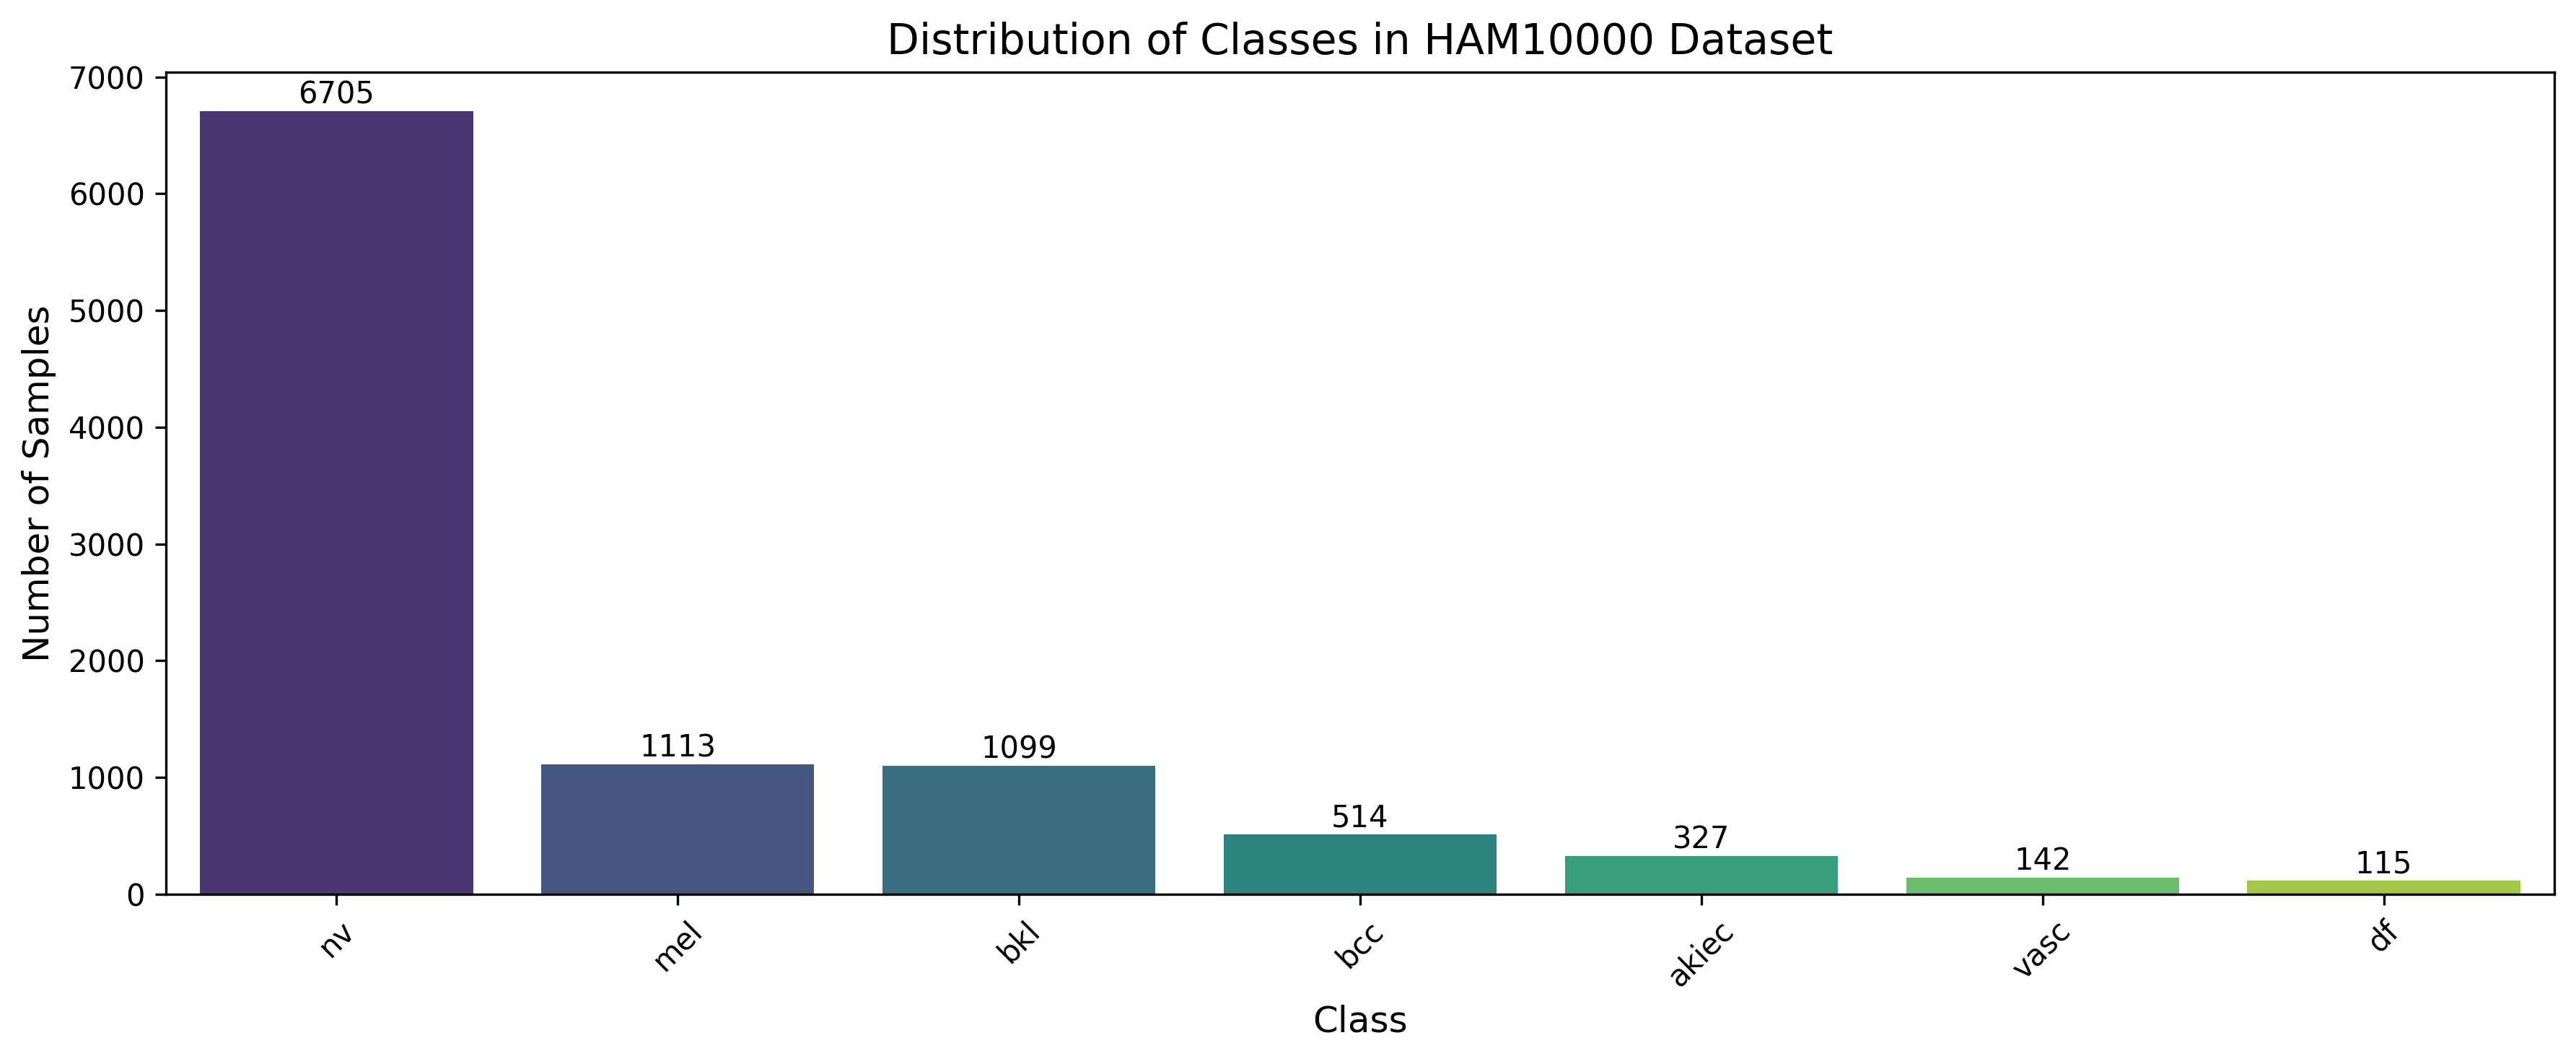

In [6]:
# Visualize Class Distribution in the HAM10000 Dataset
# Set up a high-resolution bar plot to show class imbalance
plt.figure(figsize=(12, 5), dpi=300)  # Define the size and resolution of the figure
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="viridis")  # Create the bar plot with a colormap

# Annotate each bar with the corresponding count value
for i, count in enumerate(class_distribution.values):
    plt.text(i, count + 10, f'{int(count)}', ha='center', va='bottom', fontsize=10)  # Display value above each bar

# Add informative title and axis labels
plt.title('Distribution of Classes in HAM10000 Dataset', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Adjust layout and optionally save the figure to disk
plt.tight_layout()  # Prevent clipping of tick-labels and titles
plt.savefig("ham10000_class_distribution.png", dpi=300)  # Save the plot as a high-quality image

# Show the plot in the notebook/output window
plt.show()

In [7]:
# ----------------------------------------------------
# Define Constants for Model Configuration and Training
# ----------------------------------------------------

# INPUT_SHAPE: Tuple defining the shape of input images.
# (64, 64, 3) means each image is resized to 64x64 pixels with 3 color channels (RGB).
INPUT_SHAPE = (64, 64, 3)

# NUM_CLASSES: Total number of distinct skin lesion classes to predict.
# This is derived by counting the columns in the labels CSV file, excluding the first column (image ID).
NUM_CLASSES = len(label_mapping)  # Expected to be 8 classes in HAM10000

# BATCH_SIZE: Number of images passed through the network in one forward/backward pass during training.
# Larger batch sizes require more memory but can be faster for training on GPUs.
BATCH_SIZE = 64

# EPOCHS: Number of complete passes through the training dataset.
# This determines how long the model trains — more epochs give the model more chances to learn but may cause overfitting if too high.
EPOCHS = 100

# LEARNING_RATE: Controls the step size during gradient descent updates.
# A lower learning rate allows for fine updates but may take longer to converge; too high can cause unstable training.
LEARNING_RATE = 0.0001

# Data preprocessing

In [8]:
# --------------------------------------------------------------
# Load Training Images from Disk and Preprocess
# --------------------------------------------------------------


# Load and Preprocess Images

# Initialize lists to store image data and corresponding labels
X, y = [], []

# Iterate through each row in the metadata DataFrame
for _, row in metadata.iterrows():
    image_path = row["image_path"]  # Get the full path to the image file

    # Load the image and resize it to the specified input shape (e.g., 64x64)
    img = load_img(image_path, target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))

    # Convert the image to a NumPy array and normalize pixel values to range [0, 1]
    img_array = img_to_array(img) / 255.0

    # Append the image data and corresponding label to the lists
    X.append(img_array)
    y.append(row["label"])

# At this point:
# - `X` contains normalized image data
# - `y` contains encoded integer labels for each image
# These arrays can now be used for training/validation/testing in a deep learning model

In [11]:
# --------------------------------------------------------------
# Normalize Image Data and Convert Labels to Proper Data Types
# --------------------------------------------------------------

# Convert the list of image arrays (X) to a NumPy array of type float32.
# This ensures the images are in a format suitable for training.
# Then, normalize the pixel values to the range [0, 1] by dividing by 255.0.
X = np.array(X, dtype=np.float32) / 255.0  # Normalize images to range [0, 1]

# Convert the labels array (y) to a NumPy array of type int32.
# This ensures that the labels are in a format suitable for classification tasks.
y = np.array(y, dtype=np.int32)  # Convert labels to integers

# Display the shapes of the image and label arrays to verify the preprocessing.
# X.shape gives the shape of the image data (number of images, height, width, channels)
# y.shape gives the shape of the labels (number of images,).
print("The shape of X: ",X.shape)
print("The shape of y: ",y.shape)

The shape of X:  (10015, 64, 64, 3)
The shape of y:  (10015,)


In [12]:
# Check Metadata and Analyze Class Distribution

# Check if the metadata DataFrame is empty (i.e., contains no rows)
# Useful for debugging to ensure that the dataset has been loaded correctly
# print(metadata.empty)  # Uncomment to verify: should return False if data exists

# Identify the class with the highest number of samples (i.e., the majority class)
# This is useful for analyzing class imbalance or deciding on sampling strategies
max_samples = max(metadata['dx'].value_counts())

# Print the number of samples in the top (most frequent) class
print("Number of samples in the top class:", max_samples)

Number of samples in the top class: 6705


# Step 1: Data Augmentation

In [13]:
print(f"Class distribution before augmentation: {Counter(y)}")

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

X_balanced, y_balanced = [], []
unique_classes = np.unique(y)


for cls in unique_classes:
    class_indices = np.where(y == cls)[0]
    X_class = X[class_indices]
    y_class = y[class_indices]

    n_to_generate = max_samples - len(X_class)

    # Start with existing samples
    X_balanced.append(X_class)
    y_balanced.append(y_class)

    if n_to_generate > 0:
        # Augment using ImageDataGenerator
        augmented_images = []
        augmented_labels = []

        # Flow the class images through the generator
        for batch in datagen.flow(X_class, y_class, batch_size=1, seed=42):
            augmented_images.append(batch[0][0])
            augmented_labels.append(batch[1][0])
            if len(augmented_images) >= n_to_generate:
                break

        X_balanced.append(np.array(augmented_images))
        y_balanced.append(np.array(augmented_labels))

X_balanced = np.concatenate(X_balanced)
y_balanced = np.concatenate(y_balanced)

print(f"Class distribution after augmentation: {Counter(y_balanced)}")

# Final balanced data
X, y = X_balanced, y_balanced

Class distribution before augmentation: Counter({np.int32(1): 6705, np.int32(3): 1113, np.int32(0): 1099, np.int32(5): 514, np.int32(6): 327, np.int32(4): 142, np.int32(2): 115})
Class distribution after augmentation: Counter({np.int32(0): 6705, np.int32(1): 6705, np.int32(2): 6705, np.int32(3): 6705, np.int32(4): 6705, np.int32(5): 6705, np.int32(6): 6705})


In [14]:
# Display the shapes of the balanced dataset

# Print the shape of the balanced input data (images)
# Format: (total_samples, height, width, channels)
print("Shape of Balanced Input:", X_balanced.shape)

# Print the shape of the balanced output data (labels)
# Format: (total_samples,)
print("Shape of Balanced Output:", y_balanced.shape)

# You can also directly return the shapes if needed (e.g., in notebooks or for debugging)
# X_balanced.shape, y_balanced.shape

Shape of Balanced Input: (46935, 64, 64, 3)
Shape of Balanced Output: (46935,)


# Step 2: Split the dataset into training and testing sets (80-20 split)

In [15]:
# 'train_test_split' is used to split the balanced dataset into training and testing sets
# test_size=0.2 ensures that 20% of the data will be used for testing, leaving 80% for training
# random_state=42 ensures that the split is reproducible with the same random partition each time
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Convert the training and testing labels to categorical format (one-hot encoding)
# 'tf.keras.utils.to_categorical' is used to convert integer labels into one-hot encoded vectors
# NUM_CLASSES is the total number of classes in the target variable (adjust it accordingly)
y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)

# At this stage, the dataset has been split into training and testing sets
# The labels have been converted to one-hot encoded format, and the data is ready for training and evaluation

In [16]:
print("Shape of X_train:", X_train.shape)

print("Shape of y_train:", y_train.shape)

print("Shape of X_test:", X_test.shape)

print("Shape of y_test:", y_test.shape)

print("Number of samples in X_train:", len(X_train))

print("Number of samples in y_train:", len(y_train))

print("Number of samples in X_test:", len(X_test))

print("Number of samples in y_test:", len(y_test))

Shape of X_train: (37548, 64, 64, 3)
Shape of y_train: (37548, 7)
Shape of X_test: (9387, 64, 64, 3)
Shape of y_test: (9387, 7)
Number of samples in X_train: 37548
Number of samples in y_train: 37548
Number of samples in X_test: 9387
Number of samples in y_test: 9387


In [17]:
# Convert one-hot encoded labels back to class indices
# Print the new shape of y_train and y_test to confirm the transformation
# After applying 'np.argmax', the shape of the labels should now be (None,) indicating class indices for each sample
print("New shape of y_train:", y_train.shape)
print("New shape of y_test:", y_test.shape)

New shape of y_train: (37548, 7)
New shape of y_test: (9387, 7)


# Step 3: Define CNN Model:

In [18]:
# Define Custom CNN Model using Keras Sequential API
# This model consists of several convolutional blocks followed by fully connected layers.

model = Sequential()

# -------------------------
# Block 1: Initial Convolution Layers
# -------------------------
# First Conv Layer with 32 filters and 3x3 kernel, ReLU activation, same padding
model.add(Conv2D(64, (3, 3), activation="relu", padding="SAME", input_shape=INPUT_SHAPE))
# Second Conv Layer to extract more features
model.add(Conv2D(64, (3, 3), activation="relu", padding="SAME"))
# Batch Normalization to stabilize and accelerate training
model.add(BatchNormalization())
# MaxPooling to reduce spatial dimensions (downsampling)
model.add(MaxPooling2D(pool_size=(2, 2)))

# -------------------------
# Block 2: Second Convolutional Block
# -------------------------
model.add(Conv2D(128, (3, 3), activation="relu", padding="SAME"))
model.add(Conv2D(128, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# -------------------------
# Block 3: Third Convolutional Block
# -------------------------
model.add(Conv2D(256, (3, 3), activation="relu", padding="SAME"))
model.add(Conv2D(256, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# -------------------------
# Block 4: Fourth Convolutional Block
# -------------------------
model.add(Conv2D(512, (3, 3), activation="relu", padding="SAME"))
model.add(Conv2D(512, (3, 3), activation="relu", padding="SAME"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# -------------------------
# Fully Connected (Dense) Layers
# -------------------------
# Flatten the 2D feature maps into a 1D feature vector
model.add(Flatten())
# Dropout to prevent overfitting
model.add(Dropout(0.5))

# First Dense layer with 256 neurons
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())

# Dropout to prevent overfitting
model.add(Dropout(0.5))

# Second Dense layer with 128 neurons
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())

# Third Dense layer with 64 neurons
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())

# Another Dropout layer to reduce overfitting
model.add(Dropout(0.5))

# Final Dense layer with 32 neurons
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())

# Output layer with softmax activation for multi-class classification
model.add(Dense(NUM_CLASSES, activation="softmax"))

In [19]:
# Print the model summary to see the layer details and the total number of layers
model.summary()

# Alternatively, to just count the total number of layers
total_layers = len(model.layers)
print(f"\n\nTotal number of layers in the model: {total_layers}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,832,007 (26.06 MB)

 Trainable params: 6,829,127 (26.05 MB)

 Non-trainable params: 2,880 (11.25 KB)



Total number of layers in the model: 29


# Step 4: Model Compilation

In [20]:
# Compile the model
# This step configures the model for training by specifying the optimizer, loss function, and metrics to monitor.

model.compile(
    # Optimizer: Adamax optimizer is used with a specified learning rate.
    # Adamax is a variant of the Adam optimizer that can work well with sparse gradients.
    optimizer=Adamax(learning_rate=LEARNING_RATE),

    # Loss function: Categorical Crossentropy is used for multi-class classification problems.
    # It measures the dissimilarity between the true labels and the predicted probabilities.
    loss='categorical_crossentropy',

    # Metrics: List of metrics to monitor during training and evaluation.
    # 'accuracy' will track the standard classification accuracy.
    # 'Precision' measures the proportion of positive predictions that were actually correct.
    # 'Recall' measures the proportion of actual positives that were correctly identified.
    # 'AUC' (Area Under Curve) measures the performance of the model across different thresholds.
    metrics=[
        'accuracy',  # Standard classification accuracy
        tf.keras.metrics.Precision(),  # Precision metric
        tf.keras.metrics.Recall(),  # Recall metric
        tf.keras.metrics.AUC()  # Area Under ROC Curve (AUC) metric
    ]
)

# Step 5: Model Training

In [21]:
# EarlyStopping callback: Monitors the validation accuracy (val_accuracy) and stops training if the model does not improve for a set number of epochs (patience).
# It restores the model's weights from the best epoch (restore_best_weights=True) to avoid overfitting.
early_stopping = EarlyStopping(monitor="val_accuracy", patience=20, mode="max", restore_best_weights=True)

# ReduceLROnPlateau callback: Monitors the validation loss (val_loss) and reduces the learning rate by a factor (factor=0.5) if the validation loss stops improving.
# It helps in fine-tuning the learning rate to speed up convergence after reaching a plateau.
# The minimum learning rate (min_lr=1e-6) ensures that the learning rate doesn't decrease too much.
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, mode='min', min_lr=1e-6)

# Training the model with updated configuration

# 'model.fit()' trains the model for a fixed number of epochs, using the provided training data (X_train, y_train) and validation data (X_val, y_val).
# It uses the EarlyStopping and ReduceLROnPlateau callbacks to monitor training progress and adjust the learning process dynamically.

history = model.fit(
    X_train, y_train,  # Training data and labels
    validation_data=(X_test, y_test),  # Testing data and labels used as validation data
    epochs=EPOCHS,  # Number of training epochs
    batch_size=BATCH_SIZE,  # Batch size for gradient updates
    callbacks=[early_stopping, lr_scheduler]  # List of callbacks to apply during training
)

Epoch 1/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.2213 - auc: 0.6032 - loss: 2.1872 - precision: 0.2588 - recall: 0.0762 - val_accuracy: 0.2084 - val_auc: 0.6181 - val_loss: 1.9014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3505 - auc: 0.7345 - loss: 1.7309 - precision: 0.4838 - recall: 0.1595 - val_accuracy: 0.3692 - val_auc: 0.7500 - val_loss: 1.6934 - val_precision: 0.5073 - val_recall: 0.2159 - learning_rate: 1.0000e-04
Epoch 3/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4418 - auc: 0.8034 - loss: 1.4941 - precision: 0.6223 - recall: 0.2333 - val_accuracy: 0.3282 - val_auc: 0.7284 - val_loss: 1.7290 - val_precision: 0.5284 - val_recall: 0.1764 - learning_rate: 1.0000e-04
Epoch 4/100
587/587 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.4892 - auc: 0.8410 - loss: 1.3545 - precision: 0.6768 - recall: 0.2838 - val_accuracy: 0.5456 - val_auc: 0.

# Step 6: Model Evaluation and Confusion matrix

In [22]:
# Set Seaborn theme for better plots
sns.set_theme(style="whitegrid", palette="muted")


def evaluate_model_and_confusion_matrix(model, X_train, y_train, X_test, y_test, label_mapping, history=None):
    """
    Evaluate the model performance, including metrics like accuracy, balanced accuracy, loss, and confusion matrix.
    Optionally plot training and validation performance curves if history is provided.

    Parameters:
    - model: Trained Keras model.
    - X_train: Training feature data.
    - y_train: Training labels.
    - X_test: Testing feature data.
    - y_test: Testing labels.
    - label_mapping: List of class labels for display in confusion matrix and classification report.
    - history: Optional Keras History object from model training to plot training/validation curves.

    Returns:
    - None
    """
    print("Evaluating the model...")

    # Predict class probabilities on the training set
    y_train_pred = model.predict(X_train)

    # Convert predictions from probabilities to class labels
    y_train_pred_labels = y_train_pred.argmax(axis=1)

    # Convert true labels from one-hot encoded format to class indices
    y_train_true_labels = y_train.argmax(axis=1)

    # Calculate Accuracy and Balanced Accuracy for Training
    train_acc = accuracy_score(y_train_true_labels, y_train_pred_labels)
    train_balanced_acc = balanced_accuracy_score(y_train_true_labels, y_train_pred_labels)

    # Calculate Training Loss
    train_loss = model.evaluate(X_train, y_train, verbose=0)[0]

    # Print Training Accuracy and Loss
    print(f"\nTraining Accuracy: {train_acc:.4f}")
    print(f"Training Balanced Accuracy: {train_balanced_acc:.4f}")
    print(f"Training Loss: {train_loss:.4f}")

    # Predict class probabilities on the test set
    y_test_pred = model.predict(X_test)

    # Convert predictions from probabilities to class labels
    y_test_pred_labels = y_test_pred.argmax(axis=1)

    # Convert true labels from one-hot encoded format to class indices
    y_test_true_labels = y_test.argmax(axis=1)

    # Calculate Accuracy and Balanced Accuracy for Testing
    test_acc = accuracy_score(y_test_true_labels, y_test_pred_labels)
    test_balanced_acc = balanced_accuracy_score(y_test_true_labels, y_test_pred_labels)

    # Calculate Testing Loss
    test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

    # Print Testing Accuracy and Loss
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Balanced Accuracy: {test_balanced_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    # Print Classification Report
    print("\nClassification Report:\n", classification_report(y_test_true_labels, y_test_pred_labels, target_names=label_mapping))

    # Compute confusion matrix
    cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(12, 5), dpi=300)  # High resolution for publication
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping, yticklabels=label_mapping)
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('True label', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300)  # Save at high resolution
    plt.show()

    print("\n\n")

    # ------------------------
    # Plot Training Loss/Accuracy curves (if history available)
    # ------------------------

    if history:
        plt.figure(figsize=(12, 5), dpi=300)  # High resolution for publication

        # Subplot 1: Loss curves
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss', fontsize=14)
        plt.xlabel('Epochs', fontsize=10)
        plt.ylabel('Loss', fontsize=10)
        plt.legend()
        plt.grid(True)

        # Subplot 2: Accuracy curves
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy', fontsize=14)
        plt.xlabel('Epochs', fontsize=10)
        plt.ylabel('Accuracy', fontsize=10)
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig("training_performance_curve_HAM.png", dpi=300)  # Save at high resolution
        plt.show()

Evaluating the model...
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

Training Accuracy: 0.9740
Training Balanced Accuracy: 0.9740
Training Loss: 0.0928
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Test Accuracy: 0.9287
Test Balanced Accuracy: 0.9289
Test Loss: 0.2164

Classification Report:
               precision    recall  f1-score   support

         bkl       0.87      0.81      0.84      1359
          nv       0.91      0.92      0.91      1301
          df       0.99      1.00      0.99      1328
         mel       0.85      0.82      0.84      1350
        vasc       1.00      1.00      1.00      1394
         bcc       0.93      0.98      0.96      1281
       akiec       0.94      0.98      0.96      1374

    accuracy                           0.93      9387
   macro avg       0.93      0.93      0.93      9387
weighted avg       0.93      0.93      0.93      9387



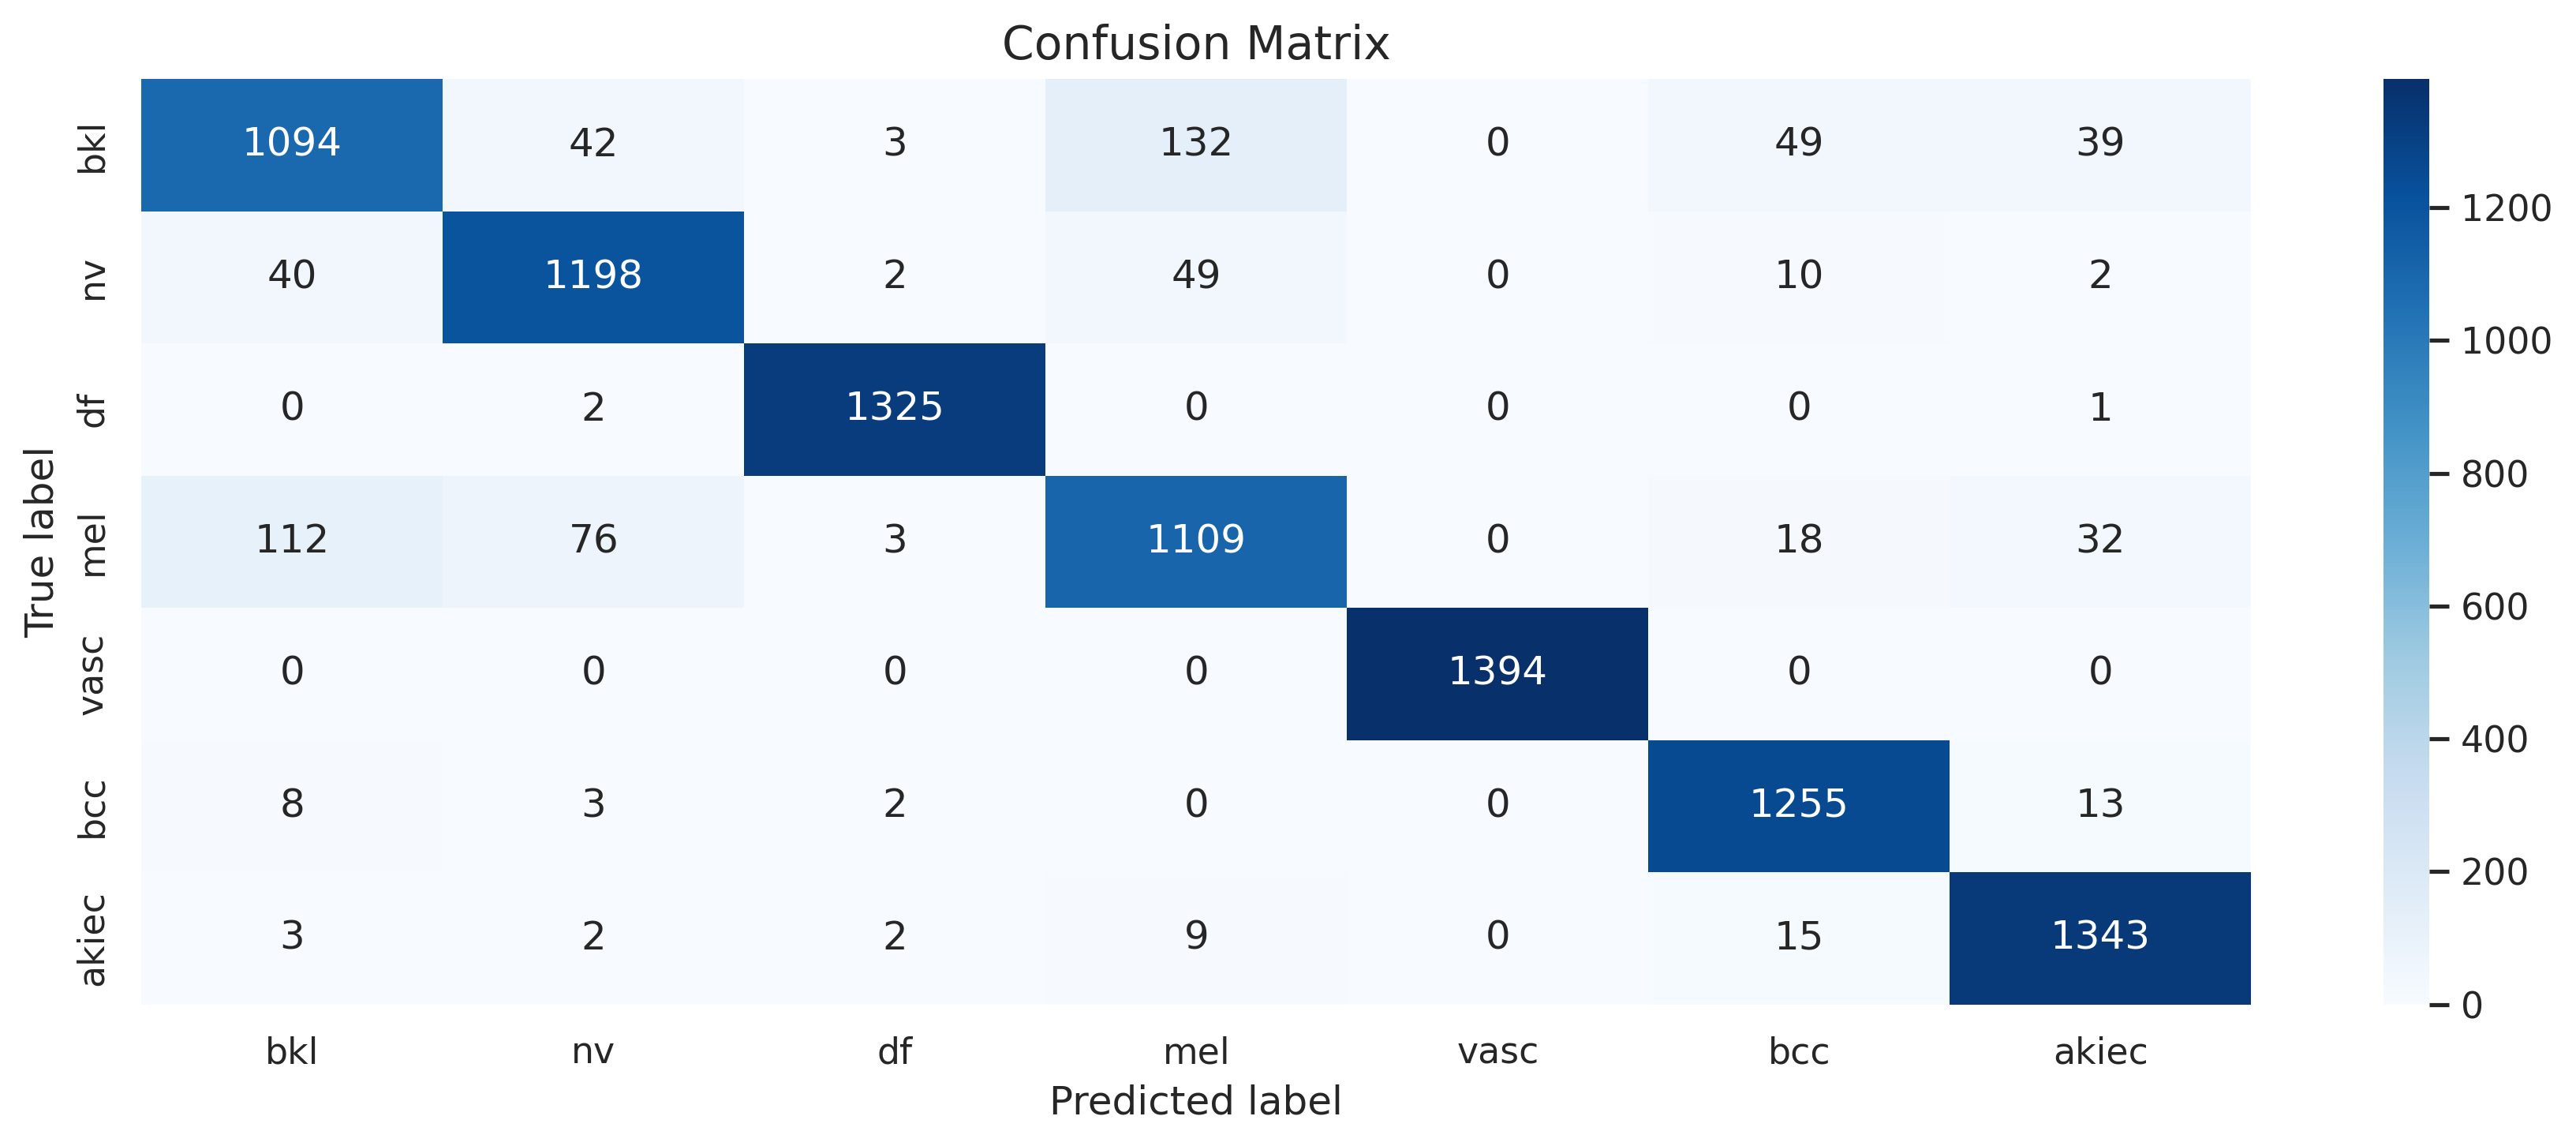

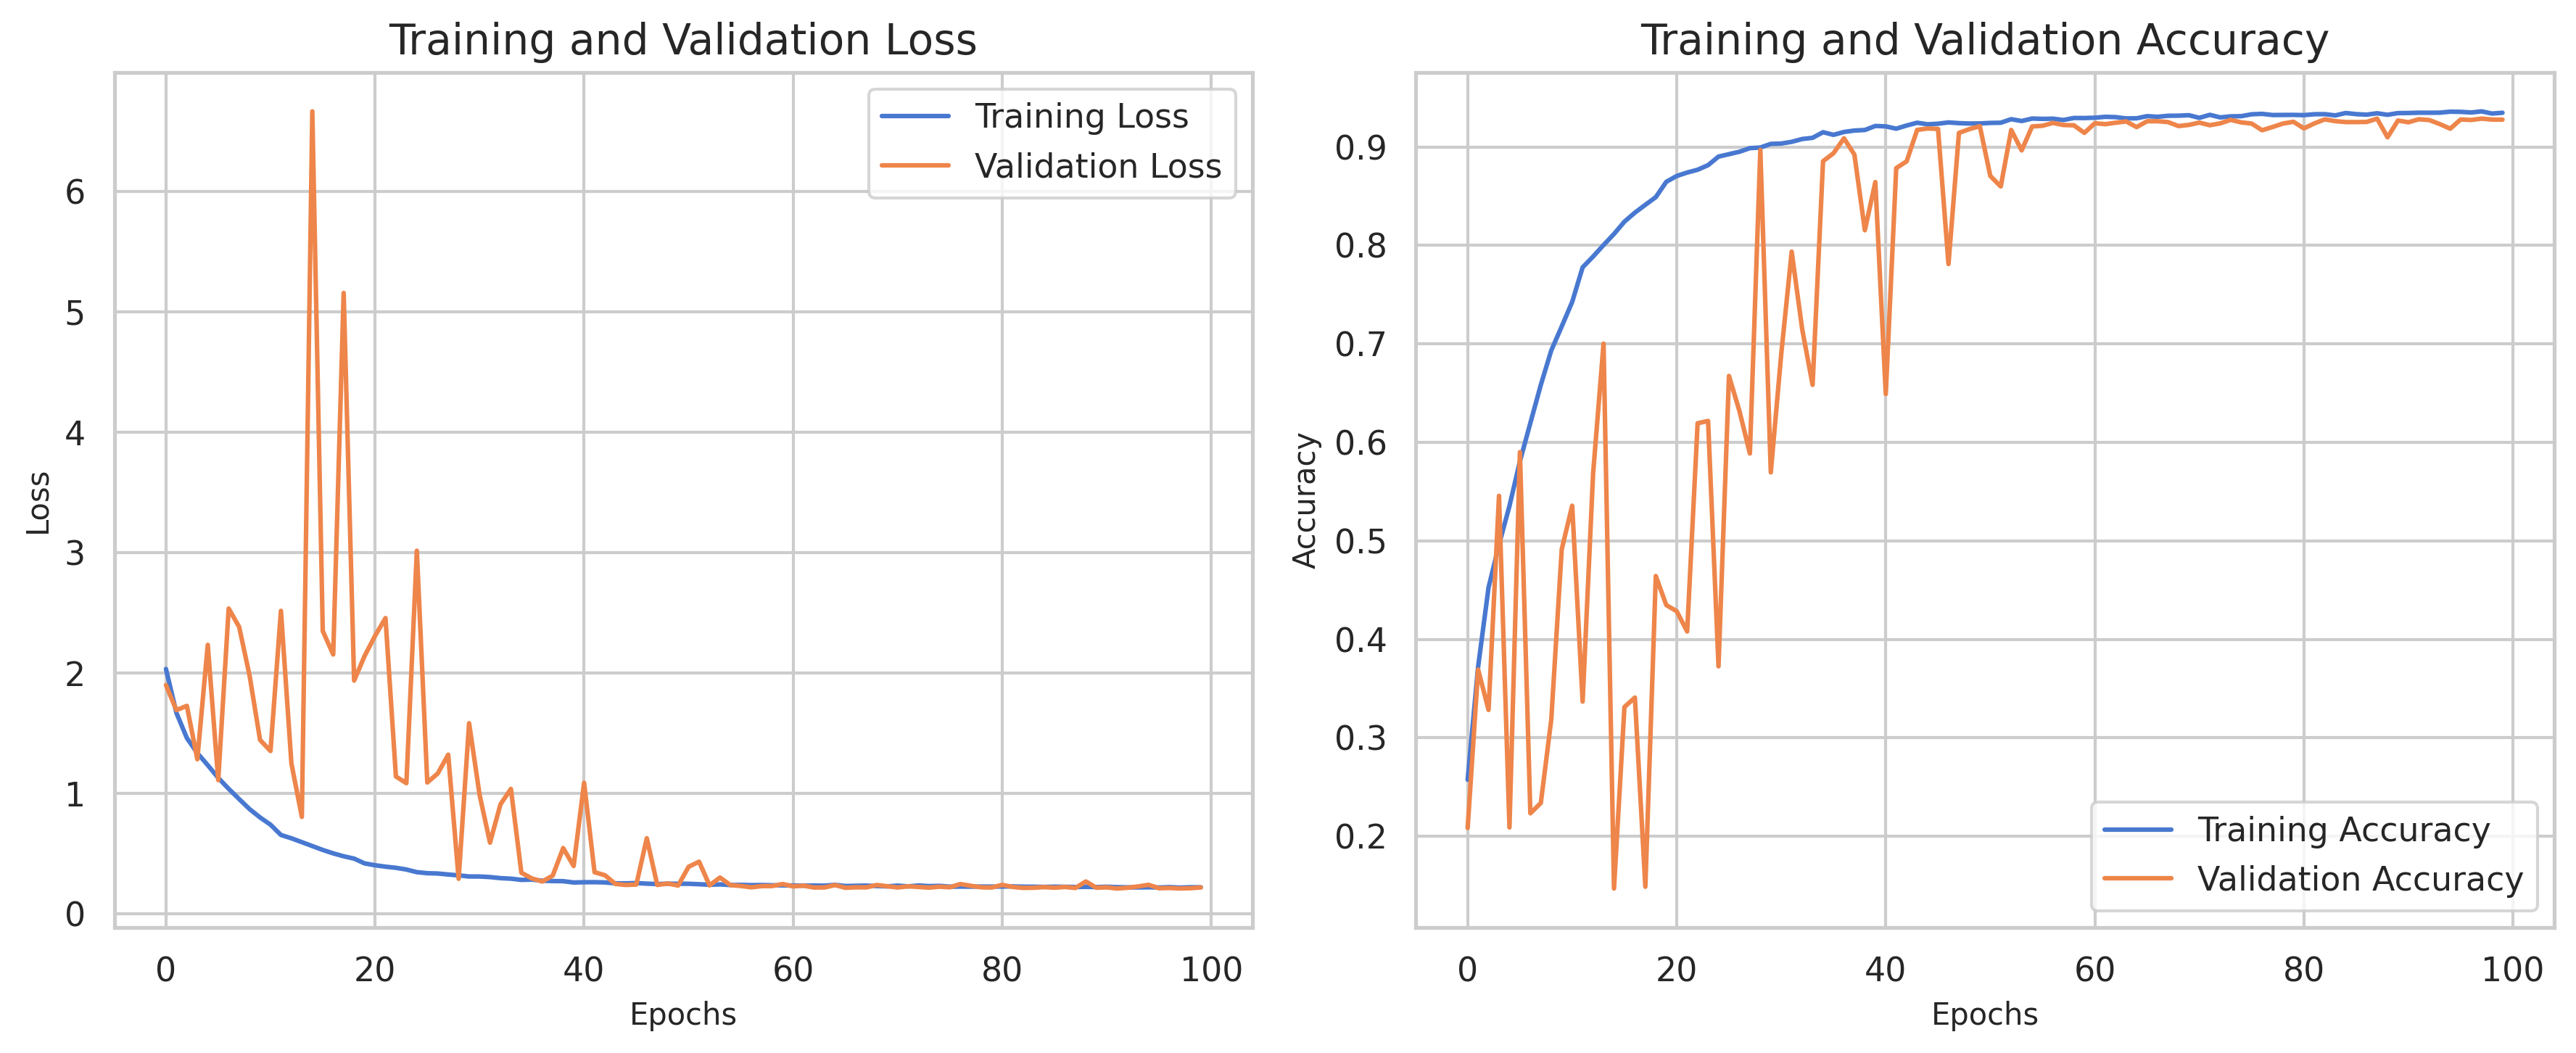

In [23]:
# Call the evaluate_model_and_confusion_matrix function

evaluate_model_and_confusion_matrix(
    model,  # Your trained Keras model
    X_train, y_train,  # Training data and labels
    X_test, y_test,  # Testing data and labels
    label_mapping=label_mapping,  # List of class labels (adjust according to your labels)
    history=history  # Optional history object from model training (can be None if not available)
)


# Step 7: Model Save

In [24]:
# Define the path where the model will be saved
model_path = '/content/drive/MyDrive/Dataset/Balanced_DA_HAM_12.h5'
my_model = '/content/drive/MyDrive/Dataset/Balanced_DA_HAM_12.keras'

# Save the trained model to the specified path
model.save(model_path)
model.save(my_model)

# Print a confirmation message indicating that the model has been saved successfully
print(f"\n Model saved successfully at {model_path}.")

print(f"\n Model saved successfully at {my_model}.")


 Model saved successfully at /content/drive/MyDrive/Dataset/Balanced_DA_HAM_12.h5.

 Model saved successfully at /content/drive/MyDrive/Dataset/Balanced_DA_HAM_12.keras.
